# Syngas prediction with consideration of time

Copyright 2021-2022 Forrest Sheng Bao at ISU, and Garrett Troll and Yinjie Tang at WUSTL

In this approach, we consider building a function 
$f(N_2, CO, H_2, CO_2, \text{flowrate}, \text{time}) = (\text{ biomass, acetate, butanol, butyrate, ethanol})$
where the outputs are concentration. 

The dataset has multiple trials (done by different labs under different conditions), 
some of which for training while the remaining of which for test. 

Because the raw data is very sparse, we also tried data augmentation (curving) using polynomial fitting, 
resulting multiple versions of the models (a model always predicts y given X, i.e., y=f(X)): 

| X (input)   | y (output) | X source | y source | note | 
| ----------- | ---------- | -------- | ---------| ---- |
| concentration | concentration | raw | raw |  |
| concentration | concentration | curved | curved |  |
| concentration | concentration | curved | raw |   |
| concentration | rate | raw | raw | impossible  |
| concentration | rate | curved | curved |   | 
| concentration | rate | curved | raw |  impossible | 

In the concentration-to-rate cases, the function $f$ becomes: 
$f(CO, H_2, CO_2, \text{flowrate}, \text{time}) = (\Delta biomass, \Delta acetate, \Delta butanol, \Delta butyrate, \Delta ethanol)$
where $\Delta = {\partial \text{ concentration} \over \partial \text{ time}}$. 


## Organization of code (key functions and variables):
* `complete_loop()`: the main function, training and test trial split is hard-coded (`training_test_composition_splits`) in it. 
  * `prepare_data_one_y()`: Return the X and y as in common ML tasks from one Pandas dataframe, given the training and test trial ID (integers). The trial ID is in the dataframe. 
  * `cv_fixed_trial_split()`: Run cross-validation to find the best hyperparameters for several types of ML regressors (NNs, SVMs, DTs, RFs, etc.). 
    * `gen_NN_uni()`: Enumerate fully-connected layers/MLPs given maximal number of layers and maximal number of neurons at each layer. 
      * `gen_NN_fixed_n_layers()`: Given the number of layers and maximal number of neurons per layer, produce various MLPs.
  * `beautiful_plot()`: Visualize the results.
  * `full_cfgs` and `test_cfgs`: two dicts storing hyperparameter grids for various types of ML regressors. 

The call of `complete_loop` is at the end of this notebook where the three versions are presented with different input CSV files and arguments. 


# 0. Load modules

In [7]:
import pandas as pd
import numpy as np
import os
import sys
import sklearn.model_selection
import matplotlib.pyplot as plt
import warnings
import sklearn, sklearn.preprocessing, sklearn.pipeline, sklearn.model_selection
import sklearn.svm, sklearn.tree, sklearn.ensemble, sklearn.neural_network
import sklearn.linear_model, sklearn.gaussian_process, sklearn.neighbors
import sklearn.multioutput
import numpy
import functools, operator, itertools
import time
import json
import scipy.stats, scipy
# import scikitlearn_plus.neural_network
warnings.filterwarnings('ignore')
import typing 
import pickle


# 1. Defining functions needed for experiments
## 1.1 The function to extraction training and test data for one output/regressor from the data

In [8]:
def prepare_data_one_y(train_df, test_df, training_trial_indexes:typing.List[int], test_trial_indexes:typing.List[int], X_columns:typing.List[str], y_column:str, scaler_type:str, columns_to_scale:typing.List[str]):
    """Prepare the X and y for one yield prediction, given the yield name, and training and test trial indexes 

    train_df, test_df: DataFrames storing X and y. We allow training data and test data to be of different sources, 
                e.g., one curved and the other raw.
    """

    # scale for X and y 
    if scaler_type == "minmax":    
        Scaler = sklearn.preprocessing.MinMaxScaler() 
    elif scaler_type == "standard":
        Scaler = sklearn.preprocessing.StandardScaler() 
    else: 
        print ("wrong scaler type ")
        exit(0) 


    Scaler.fit(train_df[columns_to_scale])
    train_df[columns_to_scale] = Scaler.transform(train_df[columns_to_scale])
    test_df[columns_to_scale] = Scaler.transform(test_df[columns_to_scale])

    # Separate training and testing 
    training_data = train_df[train_df['composition'].isin(training_trial_indexes)]
    test_data = test_df[test_df['composition'].isin(test_trial_indexes)]

    training_X, training_y = training_data[X_columns], training_data[y_column]
    test_X, test_y = test_data[X_columns], test_data[y_column]

    return training_X, training_y, test_X, test_y 


# Test 

train_df = pd.read_csv(f'../data/rates_data.csv')
print(f'Shape of the training data: {train_df.shape[0]} rows by {train_df.shape[1]} columns')

test_df = pd.read_csv(f'../data/experimental_data.csv')
print(f'Shape of the test data: {test_df.shape[0]} rows by {test_df.shape[1]} columns')

training_trial_indexes = [1,2,3,4,5,6,7]
test_trial_indexes = [8,9,10]

y_column = 'biomass (g/L)' # 'biomass', 'ethanol', 'acetate', 'butanol', or 'butyrate'
X_columns = ['flow rate (mL/min)', 'H2', 'CO', 'CO2'] 
columns_to_scale = ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)', 'flow rate (mL/min)', 'H2', 'CO', 'CO2']
training_X, training_y, test_X, test_y = prepare_data_one_y(train_df,  test_df, training_trial_indexes, test_trial_indexes, X_columns, y_column, "minmax", columns_to_scale)

Shape of the training data: 836 rows by 18 columns
Shape of the test data: 176 rows by 13 columns


## 1.2 Two functions to enumerate network structures

In [9]:
def gen_NN_fixed_n_layers(n_layers, n_neurons, neuron_step):
    """Generate NN hidden_layer_sizes of n_layers and up to n_neurons per layer 
    """
    # print (n_layers)
    if n_layers == 1: 
        return [[i] for i in range(neuron_step, n_neurons+1, neuron_step)]
    else:
        pairs =  [  (i,  tail) for tail in gen_NN_fixed_n_layers(n_layers-1, n_neurons+1, neuron_step) for i in range(neuron_step, n_neurons+1, neuron_step) ]
        return [[i]+ t for (i, t) in pairs]

# print (gen_NN_fixed_n_layers(4, 10, 5))

def gen_NN_uni(n_layers, n_neurons, layer_step, neuron_step):
    """Generate hidden layers of various number of layers and number of neurons 
    """ 
    various_NNs = [ gen_NN_fixed_n_layers(i , n_neurons, neuron_step) for i in range(2, n_layers+1, layer_step)]
    return  functools.reduce(operator.add, various_NNs)


## 1.3 The function and hyperparameter grid for grid-searching hyperparameters

In [10]:
def cv_fixed_trial_split(training_X, training_y, test_X, test_y, model_cfgs, refit:str):
    """Given training and test sets fixed on trials, do Grid search CV to tune hyperparameter and then test on test sets. 
    """

    estimator, hyperparam_grid = model_cfgs['estimator'], model_cfgs['param_grid']
    
    search = sklearn.model_selection.GridSearchCV(
            estimator = estimator, 
            param_grid = hyperparam_grid, 
            # scoring = ['neg_root_mean_squared_error'],
            # refit = 'neg_root_mean_squared_error',
            scoring = ['r2',  'neg_mean_absolute_percentage_error'],
            refit = refit,
            cv = sklearn.model_selection.ShuffleSplit(n_splits=10, test_size=0.2, random_state=0), 
            n_jobs=-1,
            verbose=0
        )

    # run grid search
    search.fit(training_X, training_y)

    # test on test set 
    test_score = search.score(test_X, test_y)
    # print ("test score %0.3f:" % test.score)

    test_y_hat = search.predict(test_X)
    cc = scipy.stats.pearsonr(test_y_hat, test_y)[0]

    return test_score, search.best_score_, search.best_params_, cc, search.cv_results_


test_cfgs = {
#     "nn":{
#         'estimator': sklearn.neural_network.MLPRegressor(shuffle=True),
# #            Test grid
#         'param_grid':   {
#             # hidden_layer_sizes made the search space many order of magnitudes larger
#             'activation':         ['tanh', 'logistic', 'relu'], 
#             'max_iter':           [400*i for i in range(1, 2)], 
#             'learning_rate':      ['adaptive']
#         }
#     },
#     "svm_rbf":{
#             'estimator': sklearn.svm.SVR(kernel='rbf'),
# #               Test grid
#             'param_grid':   {
#                 'C':       [10**i for i in range(-1, 1)], 
#                 'epsilon': [10**i for i in range(-1, 1)],
#             }
#     },
#     "rf":{
#         'estimator': sklearn.ensemble.RandomForestRegressor(),
# #            Test grid
#         'param_grid':   {
#             'n_estimators': [10*i for i in range(1, 2)],
#             'max_depth':     [2*i for i in range(1, 1+1)],
#         }
#     }, 
#     "gauss":{
#         'estimator': sklearn.gaussian_process.GaussianProcessRegressor(),
# #             Full grid 
#         'param_grid':   {
#             'alpha': [10**i for i in range(0, 5)], 
#             'normalize_y': [True, False], 
#             # 'n_restarts_optimizer': [2**i for i in range(0,5)]
#         }
#     },
    "knn":{
        'estimator': sklearn.neighbors.KNeighborsRegressor(),
#             Full grid 
        'param_grid':   {
            'n_neighbors': [i for i in range(1, 30+1)], 
            'weights': ['distance'], 
            'algorithm': ['ball_tree', 'kd_tree'], 
            'leaf_size': [5*i for i in range(1, 10+1)]                
        }
    },
}

full_cfgs = {
    "nn":{
        'estimator': sklearn.neural_network.MLPRegressor(shuffle=True),
#             Full grid
        'param_grid':   {
            'hidden_layer_sizes': gen_NN_uni(4, 100, 1, 20),  
            'activation':         ['tanh',  'relu'], 
            'max_iter':           [5000], 
            'learning_rate':      ['adaptive']
        }                
    },
    "svm_rbf":{
            'estimator': sklearn.svm.SVR(kernel='rbf'),
#       Full grid
            'param_grid':   {
                'C':       [10**i for i in range(-5, 5)], 
                'epsilon': [10**i for i in range(-5, 5)],
                'gamma':   [10**i for i in range(-5, 5)] # gamma gave me an error
            }
    },
    "rf":{
        'estimator': sklearn.ensemble.RandomForestRegressor(),
#             Full grid 
        'param_grid':   {
            'n_estimators': [10*i for i in range(1, 20)],
            'max_depth':     [2*i for i in range(20)], 
            'max_samples': [0.05*i for i in range(1, 10+1)] # max samples gave me an error
        }
    }, 
    "en":{
        'estimator': sklearn.linear_model.ElasticNet(),
#             Full grid 
        'param_grid':   {
            'alpha': [10**i for i in range(-10, 10)],
            'l1_ratio': [0.1*i for i in range(1, 10+1)] 
        }
    },
    "lasso":{
        'estimator': sklearn.linear_model.Lasso(),
#             Full grid 
        'param_grid':   {
            'alpha': [10**i for i in range(-10, 10)]
        }
    }, 
    "gauss":{
        'estimator': sklearn.gaussian_process.GaussianProcessRegressor(),
#   Full grid 
        'param_grid':   {
            'alpha': [10**i for i in range(-10, 10)], 
            'normalize_y': [True, False], 
        }
    },
    "knn":{
        'estimator': sklearn.neighbors.KNeighborsRegressor(),
#             Full grid 
        'param_grid':   {
            'n_neighbors': [i for i in range(1, 30+1)], 
            'weights': ['distance'], 
            'algorithm': ['ball_tree', 'kd_tree'], 
            'leaf_size': [5*i for i in range(1, 10+1)]                
        }
    },
}

# Test 
# for name, cfg in test_cfgs.items():
#     print (name)
#     _ = \
#     ml_fixed_trial_split(training_X, training_y, test_X, test_y, cfg, 'neg_mean_absolute_percentage_error')

## 1.4 The exhaustive CV loop

In [11]:
# def process_cv_results():
    # best for each metric 
    # for key, value in search.cv_results_.items():
        # if "_score" in key:
            

def complete_loop(train_df, test_df, model_cfgs, X_columns, y_columns, pickle_file, refit:str):
    """Complete multi-layer loops for entire ML task 

    train_df, test_df: pandas dataframes loaded from CSV files

    model_cfgs: dict, keys as str (model type) and values as sklearn grid CV parameter dict 

    y_columns: list of str, 
        To predict absolute value, use: ['biomass', 'ethanol', 'acetate', 'butanol', 'butyrate']
        To predict rate, use: ['biomass_Δ', 'ethanol_Δ', 'acetate_Δ', 'butanol_Δ', 'butyrate_Δ']

    X_columns: list of str, 
        e.g.,  ['flow rate', 'H2', 'CO', 'CO2'] 

    pickle_file: str
        where to save the results using various regressors

    refit: str
        the sklearn.metrics string 

    """

    loo = sklearn.model_selection.LeaveOneOut()
    compositions = np.array(range(1, 10+1))
    training_test_composition_splits = [
        ( (1,2,3,4,5,6,7), (8,9,10) ),  # training in compositions 1 to 7 and test in compositions 8 to 10
    ] \
    # + \
    # [(compositions[train_indexes], compositions[test_indexes]) 
    #   for train_indexes, test_indexes in 
    #       loo.split(range(7))
    # ] # leave one composition as test 

    # print (training_test_composition_splits)

    columns_to_scale = X_columns + y_columns

    full_results = {}

    for y_column in y_columns:
        # print (y_column)
        for (training_compositions, test_compositions) in training_test_composition_splits: 
            # for scaler_type in ['minmax', 'standard']:
            for scaler_type in ['minmax']:
                training_X, training_y, test_X, test_y = \
                    prepare_data_one_y(train_df, test_df, training_compositions, test_compositions, X_columns, y_column, scaler_type, columns_to_scale)
                for estimator_type, cfg in model_cfgs.items():
                # print (estimator_type)
                    test_score, train_score, best_params, cc, cv_results = \
                        cv_fixed_trial_split(training_X, training_y, test_X, test_y, cfg, refit)

                    # save result
                    if type(test_compositions) == numpy.ndarray: 
                        test_compositions = tuple(test_compositions.tolist())

                    r2_per_sk = np.mean(cv_results['mean_test_r2'])

                    cv_results.update({ "my_cc":cc, "r2_per_sk":r2_per_sk, "my_test_score": test_score, "my_train_score": train_score})
                    full_results[ (scaler_type, y_column, test_compositions, estimator_type)  ] = cv_results

                    # now print the result 
                    line = [scaler_type, y_column, test_compositions, estimator_type, "{0:.3f}".format(cc), "{0:.3f}".format(r2_per_sk), best_params]
                    line = map(str, line)
                    print ("\t".join(line))
    
    # json.dump(full_results, open("results.json", "w"), indent=2, )
    pickle.dump(full_results, open(pickle_file, "bw"))

    return full_results


##  1.5 The plot function to visualize results

In [12]:
def beautiful_plot(full_results, Y_names, metric, main_title):
    """

    metric: str, "my_cc" or "r2_per_sk'
    """
    scaler = 'minmax'
    test_trial = (8,9,10)
    bar_width = 0.3

    CC = {condition: CV_numbers[metric] for condition, CV_numbers in full_results.items() }

    # from CC to R2
    if metric == "my_cc":
        CC = {key:value**2 for key,value in CC.items()}

    model_names = [condition[3] for condition in full_results.keys()]
    model_names = list(set(model_names))
    model_names.sort() 

    table = [ 
                [ 
                    CC[(scaler, y, test_trial, model_name,)]
                    for model_name in model_names
                ]
                  for y in Y_names
            ]

    Y_max = np.nanmax(np.nanmax(table))

    figure = plt.figure(figsize=(25,4))
    index = np.arange(0, len(model_names))*bar_width + bar_width/2
    for row_number , row in enumerate(table):
        # print (100 + len(Y_names)*10 + row_number + 1, index, row)
        plt.subplot(100 + len(Y_names)*10 + row_number + 1)
        plt.ylim(0, Y_max + 0.1)
        plt.bar(index, row, 
            width = bar_width, tick_label=model_names, 
            color = plt.cm.gist_ncar(np.linspace(0, 0.5, len(model_names))))
        plt.title(Y_names[row_number])
        # break 

    figure.suptitle(main_title )

    # comparison = {}
    # for y in Y_names: # for each output or each regressor 
    #     comparison[y] = {model_name: cc for 
    #         ((scaler, y, _, model_name), cc) in CC.items()}

    
    # for 
    # bar_width = 0.5

    # tick_label = list(comparison[y].keys()) 
    # cc_value = list(comparison['butyrate'].values() )
    # index = np.arange(0, len(tick_label))*bar_width + bar_width/2
    # print (index, tick_label, cc_value)

    # plt.bar(index, cc_value , 
    #     width = bar_width, tick_label=tick_label, 
    #     color = plt.cm.gist_ncar(np.linspace(0, 0.5, len(comparison[y]))))

    
# Test 
# full_results = pickle.load(open("test.pickle", "br"))
# beautiful_plot(full_results, 
#     ['biomass', 'ethanol', 'acetate', 'butanol', 'butyrate'],
#     "my_cc",
#     "1. Concentration to concentration")


# 2. Experiments 
## 2.1 When Refit goal is MAPE
### 2.1.1. Running the experiments
**1. raw concentration => raw concentration**

In [13]:
train_df = pd.read_csv(f'../data/experimental_data.csv')
test_df  = train_df
results_raw_concentration = complete_loop(
    train_df, test_df, full_cfgs,  
    ['flow rate (mL/min)', 'N2', 'H2', 'CO', 'CO2'] , 
    ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)'],
    "raw_concentration_to_raw_concentration.pickle",
    'neg_mean_absolute_percentage_error')

minmax	biomass (g/L)	(8, 9, 10)	nn	-0.192	-0.134	{'activation': 'tanh', 'hidden_layer_sizes': [80, 60, 100, 60], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	biomass (g/L)	(8, 9, 10)	svm_rbf	nan	-0.053	{'C': 1e-05, 'epsilon': 10000, 'gamma': 1e-05}
minmax	biomass (g/L)	(8, 9, 10)	rf	0.079	nan	{'max_depth': 26, 'max_samples': 0.05, 'n_estimators': 10}
minmax	biomass (g/L)	(8, 9, 10)	en	nan	-0.057	{'alpha': 0.001, 'l1_ratio': 1.0}
minmax	biomass (g/L)	(8, 9, 10)	lasso	nan	-0.057	{'alpha': 0.001}
minmax	biomass (g/L)	(8, 9, 10)	gauss	-0.010	-1.033	{'alpha': 10000, 'normalize_y': False}
minmax	biomass (g/L)	(8, 9, 10)	knn	0.211	-0.175	{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 1, 'weights': 'distance'}
minmax	ethanol (mM)	(8, 9, 10)	nn	0.155	0.114	{'activation': 'tanh', 'hidden_layer_sizes': [60, 80, 80, 20], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	ethanol (mM)	(8, 9, 10)	svm_rbf	0.253	-0.529	{'C': 10000, 'epsilon': 1, 'gamma': 1e-05}
minmax	ethanol (

**2. curved concentration => curved concentration**

In [14]:
# Why Jupyter is bad here. 
# i want variables train_df and test_df to be different for each experiment 
# rather than being global variables overridden on experiment after the other. 

train_df = pd.read_csv(f'../data/rates_data.csv')
test_df = train_df
results_curve_concentration = complete_loop(
    train_df, test_df, full_cfgs,  
    ['flow rate (mL/min)', 'N2',  'H2', 'CO', 'CO2'] , 
    ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)'],
    "curved_concentration_to_curved_concentration.pickle",
    'neg_mean_absolute_percentage_error')

minmax	biomass (g/L)	(8, 9, 10)	nn	0.478	0.001	{'activation': 'relu', 'hidden_layer_sizes': [100, 40, 20, 20], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	biomass (g/L)	(8, 9, 10)	svm_rbf	0.525	0.046	{'C': 100, 'epsilon': 0.001, 'gamma': 1000}
minmax	biomass (g/L)	(8, 9, 10)	rf	0.625	nan	{'max_depth': 24, 'max_samples': 0.05, 'n_estimators': 20}
minmax	biomass (g/L)	(8, 9, 10)	en	0.665	0.036	{'alpha': 1e-08, 'l1_ratio': 0.1}
minmax	biomass (g/L)	(8, 9, 10)	lasso	0.665	0.037	{'alpha': 1e-10}
minmax	biomass (g/L)	(8, 9, 10)	gauss	0.216	-0.027	{'alpha': 1000000000, 'normalize_y': False}
minmax	biomass (g/L)	(8, 9, 10)	knn	0.530	0.463	{'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'distance'}
minmax	ethanol (mM)	(8, 9, 10)	nn	0.505	0.408	{'activation': 'relu', 'hidden_layer_sizes': [80, 80, 60, 80], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	ethanol (mM)	(8, 9, 10)	svm_rbf	0.473	-0.303	{'C': 1, 'epsilon': 1e-05, 'gamma': 0.01}
minmax	ethanol (

**3. curved concentration => raw concentration**

In [15]:
train_df = pd.read_csv(f'../data/rates_data.csv')
test_df = pd.read_csv(f'../data/experimental_data.csv')
results_curve_rate = complete_loop(
    train_df, test_df, full_cfgs,  
    ['flow rate (mL/min)', 'N2', 'H2', 'CO', 'CO2'] , 
    ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)'],
    "curved_concentration_to_raw_concentration.pickle",
    'neg_mean_absolute_percentage_error')

minmax	biomass (g/L)	(8, 9, 10)	nn	0.217	0.444	{'activation': 'tanh', 'hidden_layer_sizes': [20, 100, 100, 100], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	biomass (g/L)	(8, 9, 10)	svm_rbf	nan	0.097	{'C': 10000, 'epsilon': 0.1, 'gamma': 1000}
minmax	biomass (g/L)	(8, 9, 10)	rf	0.216	nan	{'max_depth': 4, 'max_samples': 0.05, 'n_estimators': 10}
minmax	biomass (g/L)	(8, 9, 10)	en	0.211	0.046	{'alpha': 1e-10, 'l1_ratio': 0.1}
minmax	biomass (g/L)	(8, 9, 10)	lasso	0.211	0.044	{'alpha': 1e-10}
minmax	biomass (g/L)	(8, 9, 10)	gauss	0.003	-0.521	{'alpha': 1000000000, 'normalize_y': False}
minmax	biomass (g/L)	(8, 9, 10)	knn	0.217	0.458	{'algorithm': 'ball_tree', 'leaf_size': 35, 'n_neighbors': 1, 'weights': 'distance'}
minmax	ethanol (mM)	(8, 9, 10)	nn	0.240	0.393	{'activation': 'tanh', 'hidden_layer_sizes': [20, 40, 20, 80], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	ethanol (mM)	(8, 9, 10)	svm_rbf	0.250	-0.549	{'C': 10000, 'epsilon': 0.1, 'gamma': 0.01}
minmax	ethanol 

**5. curved concentration => curved rate**

In [16]:
train_df = pd.read_csv(f'../data/rates_data.csv')
test_df = train_df
results_curve_rate = complete_loop(
    train_df, test_df, full_cfgs,  
    ['flow rate (mL/min)',  'N2', 'H2', 'CO', 'CO2'] , 
    ['biomass rate','ethanol rate','acetate rate','butanol rate','butyrate rate'],
    "curved_concentration_to_curved_rate.pickle",
    'neg_mean_absolute_percentage_error')

minmax	biomass rate	(8, 9, 10)	nn	-0.111	0.004	{'activation': 'relu', 'hidden_layer_sizes': [40, 80, 20, 40], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	biomass rate	(8, 9, 10)	svm_rbf	0.066	-0.174	{'C': 0.1, 'epsilon': 0.0001, 'gamma': 1000}
minmax	biomass rate	(8, 9, 10)	rf	0.109	nan	{'max_depth': 8, 'max_samples': 0.1, 'n_estimators': 20}
minmax	biomass rate	(8, 9, 10)	en	0.111	0.034	{'alpha': 1e-08, 'l1_ratio': 0.30000000000000004}
minmax	biomass rate	(8, 9, 10)	lasso	0.111	0.035	{'alpha': 1e-10}
minmax	biomass rate	(8, 9, 10)	gauss	0.111	-4.891	{'alpha': 1e-05, 'normalize_y': False}
minmax	biomass rate	(8, 9, 10)	knn	0.110	0.062	{'algorithm': 'kd_tree', 'leaf_size': 20, 'n_neighbors': 20, 'weights': 'distance'}
minmax	ethanol rate	(8, 9, 10)	nn	0.066	0.325	{'activation': 'relu', 'hidden_layer_sizes': [60, 40, 60, 20], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	ethanol rate	(8, 9, 10)	svm_rbf	0.028	0.095	{'C': 1e-05, 'epsilon': 1e-05, 'gamma': 1e-05}
minmax	et

### 2.1.2 Visualize MAPE-based results

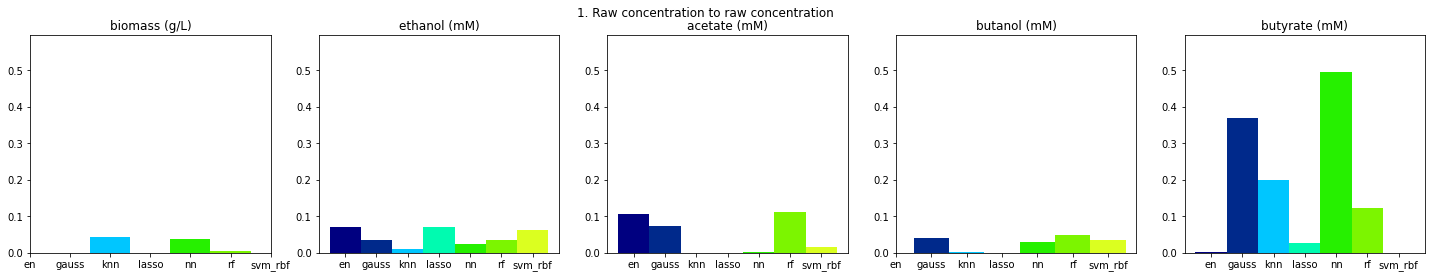

In [17]:
full_results = pickle.load(open("raw_concentration_to_raw_concentration.pickle", "br"))
beautiful_plot(full_results, 
     ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)', 'butyrate (mM)'], 
     "my_cc", 
     "1. Raw concentration to raw concentration")

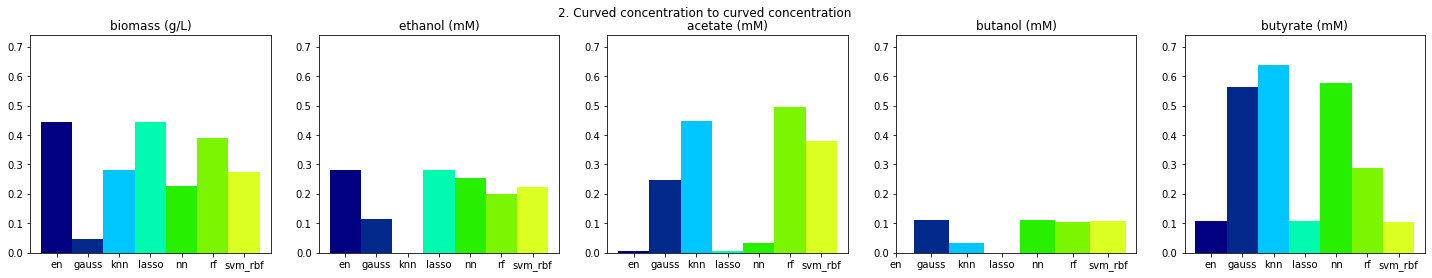

In [18]:
full_results = pickle.load(open("curved_concentration_to_curved_concentration.pickle", "br"))
beautiful_plot(full_results, 
    ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)'], 
    "my_cc", 
    "2. Curved concentration to curved concentration")

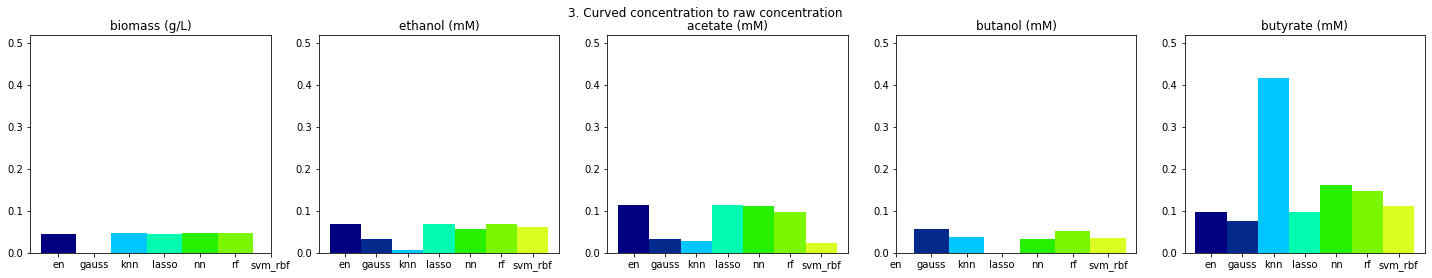

In [19]:
full_results = pickle.load(open("curved_concentration_to_raw_concentration.pickle", "br"))
beautiful_plot(full_results, 
  ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)'], 
  "my_cc", 
  "3. Curved concentration to raw concentration")

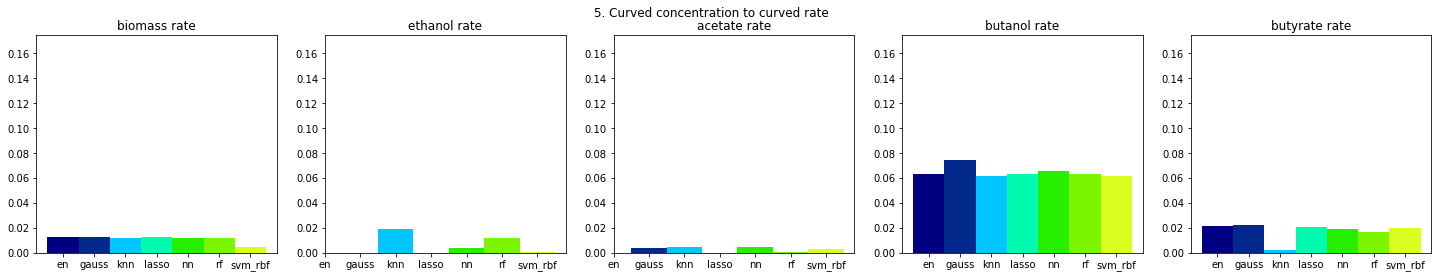

In [20]:
full_results = pickle.load(open("curved_concentration_to_curved_rate.pickle", "br"))
beautiful_plot(full_results, 
  ['biomass rate', 'ethanol rate', 'acetate rate', 'butanol rate', 'butyrate rate'],  
  "my_cc",
  "5. Curved concentration to curved rate")

## 2.2 When Refit goal is R2

### 2.2.1 Running the experiments

**1. raw concentration => raw concentration**

In [21]:
train_df = pd.read_csv(f'../data/experimental_data.csv')
test_df  = train_df
results_raw_concentration = complete_loop(
    train_df, test_df, full_cfgs,  
    ['flow rate (mL/min)',  'N2', 'H2', 'CO', 'CO2'] , 
    ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)'],
    "raw_concentration_to_raw_concentration_r2.pickle",
    'r2')

minmax	biomass (g/L)	(8, 9, 10)	nn	-0.115	-0.132	{'activation': 'tanh', 'hidden_layer_sizes': [40, 100, 40, 100], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	biomass (g/L)	(8, 9, 10)	svm_rbf	0.132	-0.053	{'C': 0.01, 'epsilon': 1e-05, 'gamma': 1000}
minmax	biomass (g/L)	(8, 9, 10)	rf	0.212	nan	{'max_depth': 16, 'max_samples': 0.05, 'n_estimators': 100}
minmax	biomass (g/L)	(8, 9, 10)	en	nan	-0.057	{'alpha': 0.001, 'l1_ratio': 1.0}
minmax	biomass (g/L)	(8, 9, 10)	lasso	nan	-0.057	{'alpha': 0.001}
minmax	biomass (g/L)	(8, 9, 10)	gauss	0.131	-1.033	{'alpha': 1000000000, 'normalize_y': True}
minmax	biomass (g/L)	(8, 9, 10)	knn	0.212	-0.175	{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 19, 'weights': 'distance'}
minmax	ethanol (mM)	(8, 9, 10)	nn	0.249	0.114	{'activation': 'tanh', 'hidden_layer_sizes': [20, 100, 60, 60], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	ethanol (mM)	(8, 9, 10)	svm_rbf	0.262	-0.529	{'C': 1000, 'epsilon': 10, 'gamma': 1e-05}
minmax	eth

**2. curved concentration => curved concentration**

In [22]:
train_df = pd.read_csv(f'../data/rates_data.csv')
test_df = train_df
results_curve_concentration = complete_loop(
    train_df, test_df, full_cfgs,  
    ['flow rate (mL/min)', 'N2', 'H2', 'CO', 'CO2'] , 
    ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)'],
    "curved_concentration_to_curved_concentration_r2.pickle",
    'r2')

minmax	biomass (g/L)	(8, 9, 10)	nn	-0.370	0.001	{'activation': 'relu', 'hidden_layer_sizes': [100, 100, 100], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	biomass (g/L)	(8, 9, 10)	svm_rbf	0.622	0.046	{'C': 1000, 'epsilon': 0.1, 'gamma': 10}
minmax	biomass (g/L)	(8, 9, 10)	rf	0.564	nan	{'max_depth': 34, 'max_samples': 0.30000000000000004, 'n_estimators': 10}
minmax	biomass (g/L)	(8, 9, 10)	en	0.665	0.036	{'alpha': 1e-10, 'l1_ratio': 1.0}
minmax	biomass (g/L)	(8, 9, 10)	lasso	0.665	0.037	{'alpha': 1e-10}
minmax	biomass (g/L)	(8, 9, 10)	gauss	0.644	-0.027	{'alpha': 1e-06, 'normalize_y': True}
minmax	biomass (g/L)	(8, 9, 10)	knn	0.621	0.463	{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 30, 'weights': 'distance'}
minmax	ethanol (mM)	(8, 9, 10)	nn	0.553	0.408	{'activation': 'relu', 'hidden_layer_sizes': [80, 40, 100, 100], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	ethanol (mM)	(8, 9, 10)	svm_rbf	0.552	-0.303	{'C': 10000, 'epsilon': 10, 'gamma': 0.0001}
minmax

**3. curved concentration => raw concentration**

In [23]:
train_df = pd.read_csv(f'../data/rates_data.csv')
test_df = pd.read_csv(f'../data/experimental_data.csv')
results_curve_rate = complete_loop(
    train_df, test_df, full_cfgs,  
    ['flow rate (mL/min)', 'N2', 'H2', 'CO', 'CO2'] , 
    ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)'],
    "curved_concentration_to_raw_concentration_r2.pickle",
    'r2')

minmax	biomass (g/L)	(8, 9, 10)	nn	0.218	0.445	{'activation': 'tanh', 'hidden_layer_sizes': [100, 80, 20, 100], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	biomass (g/L)	(8, 9, 10)	svm_rbf	0.215	0.097	{'C': 10000, 'epsilon': 0.01, 'gamma': 0.001}
minmax	biomass (g/L)	(8, 9, 10)	rf	0.218	nan	{'max_depth': 38, 'max_samples': 0.1, 'n_estimators': 60}
minmax	biomass (g/L)	(8, 9, 10)	en	0.211	0.046	{'alpha': 1e-10, 'l1_ratio': 0.1}
minmax	biomass (g/L)	(8, 9, 10)	lasso	0.211	0.044	{'alpha': 1e-10}
minmax	biomass (g/L)	(8, 9, 10)	gauss	0.216	-0.521	{'alpha': 0.1, 'normalize_y': True}
minmax	biomass (g/L)	(8, 9, 10)	knn	0.213	0.458	{'algorithm': 'kd_tree', 'leaf_size': 5, 'n_neighbors': 30, 'weights': 'distance'}
minmax	ethanol (mM)	(8, 9, 10)	nn	0.263	0.393	{'activation': 'relu', 'hidden_layer_sizes': [60, 80, 100, 100], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	ethanol (mM)	(8, 9, 10)	svm_rbf	0.256	-0.549	{'C': 1000, 'epsilon': 0.1, 'gamma': 0.1}
minmax	ethanol (mM)	(8

**5. curved concentration => curved rate**

In [24]:
train_df = pd.read_csv(f'../data/rates_data.csv')
test_df = train_df
results_curve_rate = complete_loop(
    train_df, test_df, full_cfgs,  
    ['flow rate (mL/min)', 'N2', 'H2', 'CO', 'CO2'] , 
    ['biomass rate','ethanol rate','acetate rate','butanol rate','butyrate rate'],
    "curved_concentration_to_curved_rate_r2.pickle",
    'r2')

minmax	biomass rate	(8, 9, 10)	nn	-0.041	0.004	{'activation': 'tanh', 'hidden_layer_sizes': [100, 100, 100, 100], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	biomass rate	(8, 9, 10)	svm_rbf	0.093	-0.174	{'C': 0.1, 'epsilon': 0.1, 'gamma': 1000}
minmax	biomass rate	(8, 9, 10)	rf	0.107	nan	{'max_depth': 30, 'max_samples': 0.1, 'n_estimators': 20}
minmax	biomass rate	(8, 9, 10)	en	0.111	0.034	{'alpha': 1e-06, 'l1_ratio': 0.1}
minmax	biomass rate	(8, 9, 10)	lasso	0.111	0.035	{'alpha': 1e-05}
minmax	biomass rate	(8, 9, 10)	gauss	0.111	-4.891	{'alpha': 1e-09, 'normalize_y': False}
minmax	biomass rate	(8, 9, 10)	knn	0.111	0.062	{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 28, 'weights': 'distance'}
minmax	ethanol rate	(8, 9, 10)	nn	-0.009	0.325	{'activation': 'tanh', 'hidden_layer_sizes': [60, 100, 80, 20], 'learning_rate': 'adaptive', 'max_iter': 5000}
minmax	ethanol rate	(8, 9, 10)	svm_rbf	0.106	0.095	{'C': 1000, 'epsilon': 10, 'gamma': 0.001}
minmax	ethanol rate	(8,

### 2.2.2 Visualize R2-based results

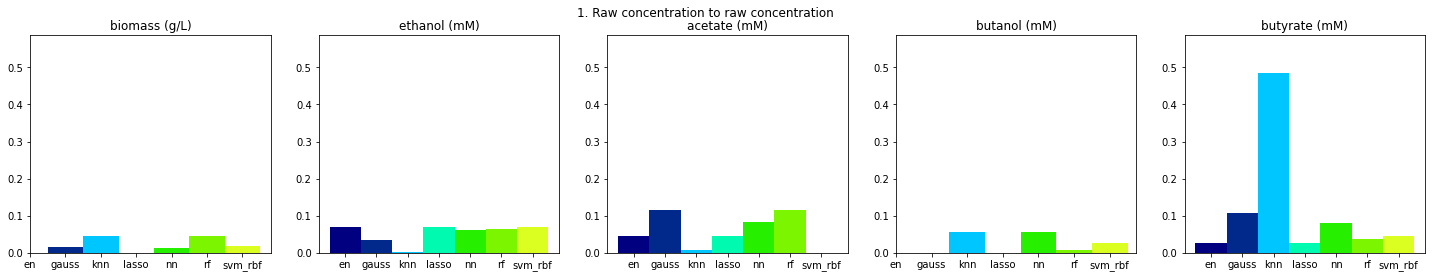

In [25]:
full_results = pickle.load(open("raw_concentration_to_raw_concentration_r2.pickle", "br"))
beautiful_plot(full_results, 
  ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)'], 
  "my_cc", 
  "1. Raw concentration to raw concentration")

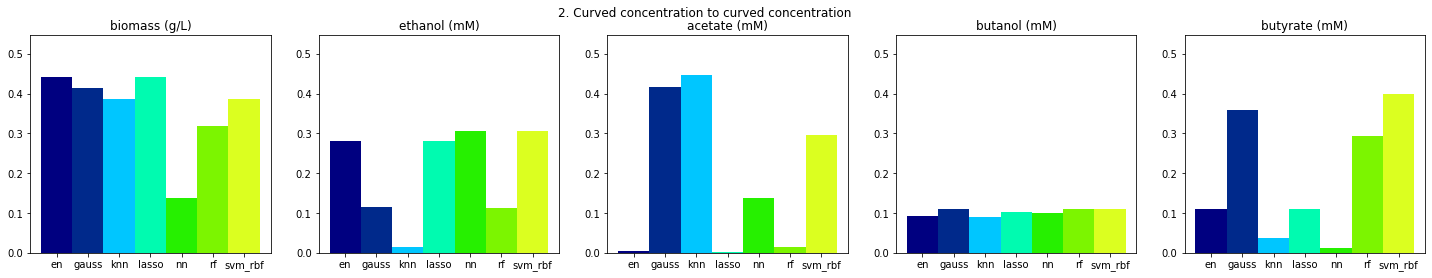

In [26]:
full_results = pickle.load(open("curved_concentration_to_curved_concentration_r2.pickle", "br"))
beautiful_plot(full_results, 
  ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)'], 
  "my_cc", 
  "2. Curved concentration to curved concentration")

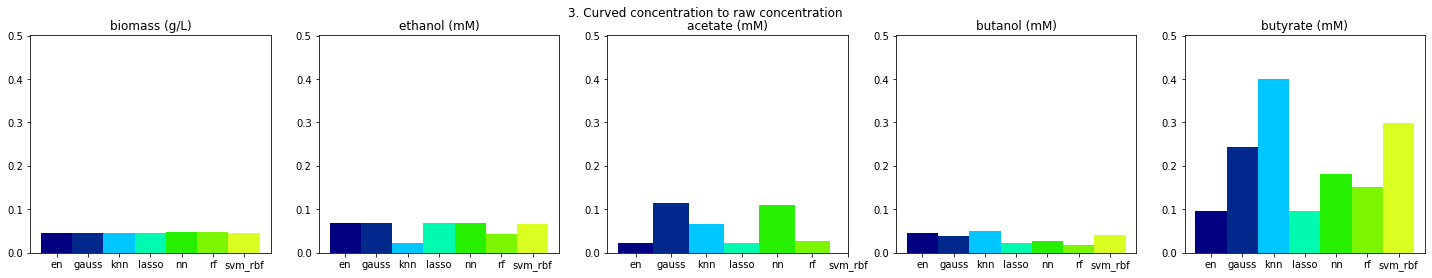

In [27]:
full_results = pickle.load(open("curved_concentration_to_raw_concentration_r2.pickle", "br"))
beautiful_plot(full_results,
  ['biomass (g/L)','ethanol (mM)','acetate (mM)','butanol (mM)','butyrate (mM)'],
  "my_cc", 
  "3. Curved concentration to raw concentration")

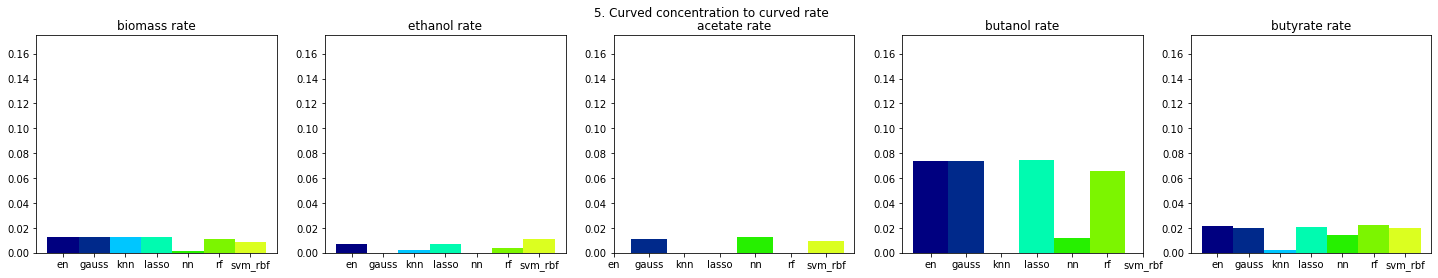

In [28]:
full_results = pickle.load(open("curved_concentration_to_curved_rate_r2.pickle", "br"))
beautiful_plot(full_results, 
  ['biomass rate', 'ethanol rate', 'acetate rate', 'butanol rate', 'butyrate rate'],  
  "my_cc", 
  "5. Curved concentration to curved rate")